In [1]:
## Logistic Regression on Amazon FFR 


# Data source - URL https://www.kaggle.com/snap/amazon-fine-food-reviews

## Data Contains reviews of fine food from Amazon. 
## It includes information about product, user, ratings, text review. 



In [2]:
## Objective: 
    # 1. Apply Decision Tree on Amazon FFR using BOW, Word2Vec, TFIDF, AvgWord2Vec
    # 2. Metrics: Accuracy, precision, recall, f1-score etc. Confusion matrix
    # 3. Use GridSearchCV and RandomSearchCV to find out best Depth

## Predict the Polarity of a given review

In [3]:
## Columns 
    # 1.Id
    # 2.ProductId - unique identifier for the product
    # 3.UserId - unqiue identifier for the user
    # 4.ProfileName
    # 5.HelpfulnessNumerator - number of users who found the review helpful
    # 6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    # 7.Score - rating between 1 and 5
    # 8.Time - timestamp for the review
    # 9.Summary - brief summary of the review
    # 10.Text - text of the review

In [4]:
#######################################################################

# Lets start with imports 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
## Load from SQL file (sqlite)

con = sql.connect('final.sqlite') ## This file obtained after text preprocessing in previous chapter 

df = pd.read_sql_query(''' SELECT * from Reviews''', con)

df.head()

index  Id   ProductId          UserId                      ProfileName  \
0      0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1      1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2      2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3      3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4      4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  Positive  1303862400   
1                     0                       0  Negative  1346976000   
2                     1                       1  Positive  1219017600   
3                     3                       3  Negative  1307923200   
4                     0                       0  Positive  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3         Cough Medicine  If you are looking for the secret ingredient i...   
4            Great taffy  Great taffy at a great price.  There was a wid...   

                                         CleanedText CleanedText_NoStem  
0  b'bought sever vital can dog food product foun...                b''  
1  b'product arriv label jumbo salt peanutsth pea...                b''  
2  b'confect around centuri light pillowi citrus ...                b''  
3  b'look secret ingredi robitussin believ found ...                b''  
4  b'great taffi great price wide assort yummi ta...                b''

In [6]:
print (df.shape)
print (df['Score'].size)
df.describe()

(364171, 13)
364171


index             Id  HelpfulnessNumerator  \
count  364171.000000  364171.000000         364171.000000   
mean   241825.377603  261814.561014              1.739021   
std    154519.869452  166958.768333              6.723921   
min         0.000000       1.000000              0.000000   
25%    104427.500000  113379.500000              0.000000   
50%    230033.000000  249445.000000              0.000000   
75%    376763.500000  407408.500000              2.000000   
max    525813.000000  568454.000000            866.000000   

       HelpfulnessDenominator          Time  
count           364171.000000  3.641710e+05  
mean                 2.186841  1.296135e+09  
std                  7.348482  4.864772e+07  
min                  0.000000  9.393408e+08  
25%                  0.000000  1.270858e+09  
50%                  1.000000  1.311379e+09  
75%                  2.000000  1.332893e+09  
max                878.000000  1.351210e+09

In [7]:
### Convert Score back to 1 or 0 

def polarity(x):
    if x == 'Positive':
        return 1
    return 0

df['Score'] = df['Score'].map(polarity)

df.head()

index  Id   ProductId          UserId                      ProfileName  \
0      0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1      1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2      2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3      3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4      4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   
3                     3                       3      0  1307923200   
4                     0                       0      1  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3         Cough Medicine  If you are looking for the secret ingredient i...   
4            Great taffy  Great taffy at a great price.  There was a wid...   

                                         CleanedText CleanedText_NoStem  
0  b'bought sever vital can dog food product foun...                b''  
1  b'product arriv label jumbo salt peanutsth pea...                b''  
2  b'confect around centuri light pillowi citrus ...                b''  
3  b'look secret ingredi robitussin believ found ...                b''  
4  b'great taffi great price wide assort yummi ta...                b''

In [8]:
## Select samples 

n_samples = 20000
df_sample = df.sample(n_samples)

## Sorting based on Time 
df_sample.sort_values('Time', inplace=True)
df_sample.head()

index      Id   ProductId          UserId         ProfileName  \
169328  212519  230334  B00004RYGX  A1GB1Q193DNFGR    Bruce Lee Pullen   
169340  212531  230346  B00004RYGX  A1ZH086GZYL5MZ         Doug DeBolt   
117925  138707  150525  0006641040  A2QID6VCFTY51R                Rick   
161885  202469  219388  B00005IX98  A24IUOMVERXVEG  Rick "rick_street"   
161893  202477  219396  B00005IX98   AGUF1WPEG4GSM          "lchang44"   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
169328                     5                       5      1   970531200   
169340                     2                       2      1  1013385600   
117925                     1                       2      1  1025481600   
161885                    11                      11      1  1036108800   
161893                     5                       8      0  1055376000   

                                                  Summary  \
169328       Fabulous Comedic Fanasy Directed by a Master   
169340                       A little gross, a lot of fun   
117925  In December it will be, my snowman's anniversa...   
161885                         Great Easy cup of Espresso   
161893                           Almost expired, Sept '03   

                                                     Text  \
169328  Beetlejuice is an awe-inspiring wonderfully am...   
169340  Michael Keaton was already on his way to being...   
117925  My daughter loves all the "Really Rosie" books...   
161885  I've purchased both the Espressione Espresso (...   
161893  I returned this due to the very short/brief ex...   

                                              CleanedText CleanedText_NoStem  
169328  b'beetlejuic wonder amus comed romp explor inc...                b''  
169340  b'michael keaton alreadi way major star play g...                b''  
117925  b'daughter love realli rosi book introduc real...                b''  
161885  b'ive purchas espression espresso classic arab...                b''  
161893  b'return due shortbrief expir date sept would ...                b''

In [9]:
## Saving to File 

import pickle

def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

savetofile(df_sample, "DT_data_20k")
df_sample = openfromfile("DT_data_20k")

In [10]:
df.describe()

index             Id  HelpfulnessNumerator  \
count  364171.000000  364171.000000         364171.000000   
mean   241825.377603  261814.561014              1.739021   
std    154519.869452  166958.768333              6.723921   
min         0.000000       1.000000              0.000000   
25%    104427.500000  113379.500000              0.000000   
50%    230033.000000  249445.000000              0.000000   
75%    376763.500000  407408.500000              2.000000   
max    525813.000000  568454.000000            866.000000   

       HelpfulnessDenominator          Score          Time  
count           364171.000000  364171.000000  3.641710e+05  
mean                 2.186841       0.843178  1.296135e+09  
std                  7.348482       0.363633  4.864772e+07  
min                  0.000000       0.000000  9.393408e+08  
25%                  0.000000       1.000000  1.270858e+09  
50%                  1.000000       1.000000  1.311379e+09  
75%                  2.000000       1.000000  1.332893e+09  
max                878.000000       1.000000  1.351210e+09

In [11]:
### Decision Tree, BOW , Unigram

## Terms: Entropy, GiniImpurity, Informatio Gain, Tree Depth, Node (Root Node, Parent Node, Leaf Node)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

uni_gram = CountVectorizer() ## By Default it is uni_gram 

X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                   df_sample["Score"].values, 
                                                   test_size=0.3,
                                                   shuffle=False,
                                                   random_state=1)

X_train = uni_gram.fit_transform(X_train)

## Standardize
scale = preprocessing.StandardScaler(with_mean=False)
X_train_std = scale.fit_transform(X_train)


## Normalise X_train 
X_train = preprocessing.normalize(X_train)

print ("X_train Shape : ", X_train.shape)


X_test = uni_gram.transform(X_test)

## Standardize
X_test_std = scale.fit_transform(X_test)


## Normalise X_train 
X_test = preprocessing.normalize(X_test)

print ("X_test Shape : ", X_test.shape)

print ("X_train Standard : \n")
print ((X_train_std.toarray()[0:5, :], X_train_std.shape, np.count_nonzero(X_train_std.toarray())))

print ("X_test Standard : \n")
print ((X_test_std.toarray()[0:5, :], X_test_std.shape, np.count_nonzero(X_test_std.toarray())))


X_train Shape :  (14000, 23760)
X_test Shape :  (6000, 23760)
X_train Standard : 

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), (14000, 23760), 441830)
X_test Standard : 

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), (6000, 23760), 190044)


In [22]:
### TimeSeries Split 

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train, cv in tscv.split(X_train):
    print (X_train[train].shape, X_train[cv].shape)

(2335, 23760) (2333, 23760)
(4668, 23760) (2333, 23760)
(7001, 23760) (2333, 23760)
(9334, 23760) (2333, 23760)
(11667, 23760) (2333, 23760)


In [23]:
%%time
############# Lets start building model 
## Findout max_depth using Timeseriesplit (Forward Chaining Cross Validation)

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

var = randint(2, 300)

clf = DecisionTreeClassifier()

param_grid = {'max_depth':sorted(var.rvs(10))} #params we need to try on classifier

tscv = TimeSeriesSplit(n_splits=5) #For time based splitting

gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1', n_jobs=-1)

gsv.fit(X_train,y_train)

savetofile(gsv,"DT_gsv_uni")

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: ", (gsv.best_score_*100))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


Best HyperParameter:  {'max_depth': 25}
Best Accuracy:  90.9951745751308
Wall time: 1min 19s


25  :  0.9099517457513081
34  :  0.9075059025997125
51  :  0.9045493914657828
75  :  0.9019697978949596
152  :  0.9013123697212971
206  :  0.899467624865393
213  :  0.9013108726919512
242  :  0.8996181085415358
258  :  0.9005507187677494
281  :  0.9013376946181874


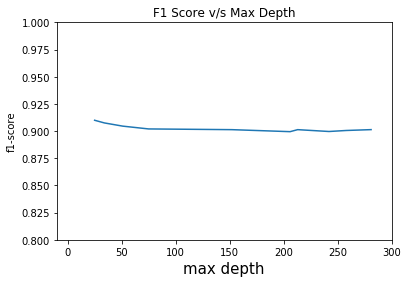

[mean: 0.90995, std: 0.00467, params: {'max_depth': 25},
 mean: 0.90751, std: 0.00548, params: {'max_depth': 34},
 mean: 0.90455, std: 0.00570, params: {'max_depth': 51},
 mean: 0.90197, std: 0.00690, params: {'max_depth': 75},
 mean: 0.90131, std: 0.00768, params: {'max_depth': 152},
 mean: 0.89947, std: 0.00644, params: {'max_depth': 206},
 mean: 0.90131, std: 0.00512, params: {'max_depth': 213},
 mean: 0.89962, std: 0.00673, params: {'max_depth': 242},
 mean: 0.90055, std: 0.00654, params: {'max_depth': 258},
 mean: 0.90134, std: 0.00562, params: {'max_depth': 281}]

In [36]:
## Lets Plot DT 
from matplotlib import pyplot as plt

%matplotlib inline

gsv = openfromfile("DT_gsv_uni")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
    print (a[0]['max_depth'], " : ", a[1])
plt.xlim(-10,300)
plt.ylim(0.8,1)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

gsv.grid_scores_

Accuracy  84.45
Precision  0.8731508875739645
Recall  0.9502918092171463
F1-Score  0.9100896212778259
Wall time: 2.94 s


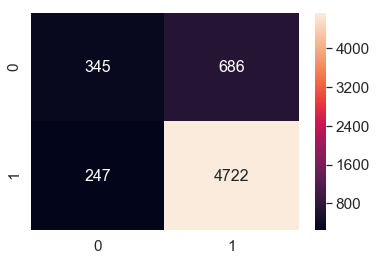

In [38]:
%%time
### Accuracy DT 

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

model = DecisionTreeClassifier(max_depth=gsv.best_params_['max_depth'])
## max_depth = 25

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

tree.export_graphviz(model, out_file="DT_gsv_unigram.dot")

# Generated Tree 

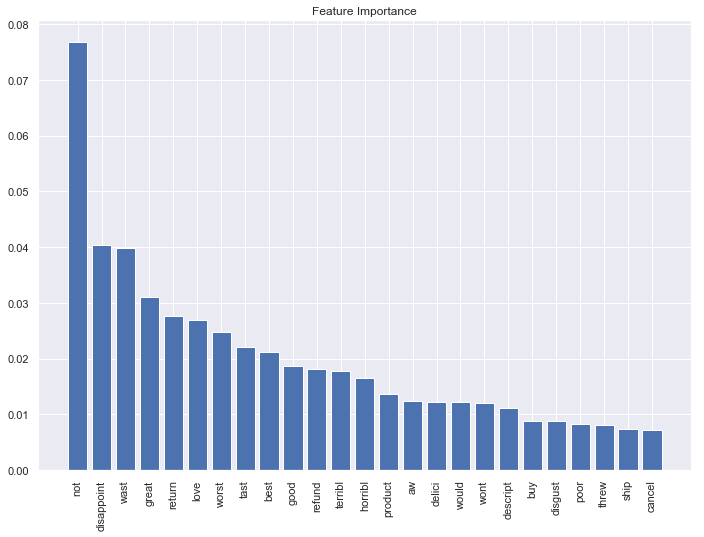

In [42]:
#### Lets Check Feature importance 

## lets check out top 25 Features 

important = model.feature_importances_

## sort feature Importances in descneding Order 

indices = np.argsort(important)[::-1][:25]


# Rearrange feature names so they match the sorted feature importances
names = uni_gram.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})
# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), important[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

In [54]:
%%time
## Bi Gram - BOW, Decision Tree

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                    df_sample['Score'].values,
                                                    test_size=0.3,
                                                    shuffle=False)

bi_gram = CountVectorizer(ngram_range=(1, 2))

X_train = bi_gram.fit_transform(X_train)

## normalize 

X_train = preprocessing.normalize(X_train)

X_test = bi_gram.transform(X_test)
X_test = preprocessing.normalize(X_test)

print ("X_train = ", X_train.shape)
print ("X_test = ", X_test.shape)


X_train =  (14000, 317810)
X_test =  (6000, 317810)
Wall time: 5.13 s


In [55]:
%%time 

#### DT, BOW, Bi-gram, GridSearchCV

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

var = randint(2, 300)

model = DecisionTreeClassifier()

param_grid = {'max_depth': sorted(var.rvs(5))}

tscv = TimeSeriesSplit(n_splits=5)

gsv = GridSearchCV(model, param_grid, cv=tscv, verbose=1, n_jobs=-1, scoring='f1')
gsv.fit(X_train, y_train)

savetofile(gsv, "DT_Bigram_GSV")

print ("Best Param : ", gsv.best_params_)
print ("Best Score/Accuracy : ", gsv.best_score_ * 100)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.1min finished


Best Param :  {'max_depth': 58}
Best Score/Accuracy :  91.23787981300052
Wall time: 3min 40s


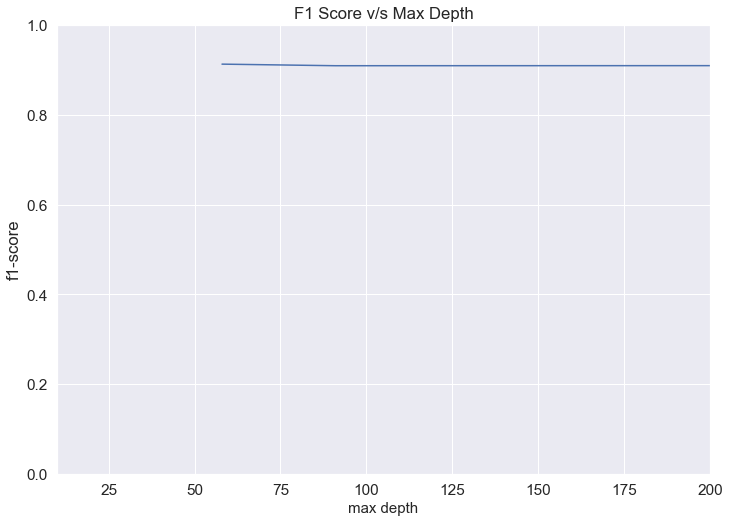

In [58]:
## Plotting 

gsv = openfromfile("DT_Bigram_GSV")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(10,200)
plt.ylim(0,1)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

Accuracy  83.15
Precision  0.8830816879597367
Recall  0.9180921714630711
F1-Score  0.9002466699555994
Wall time: 34.3 s


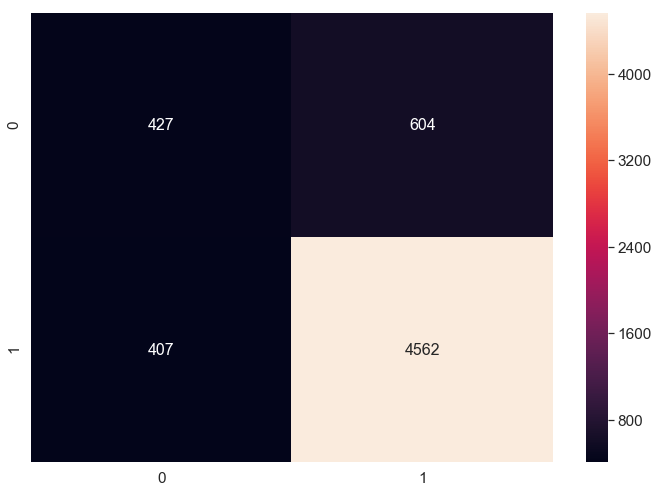

In [59]:
%%time
### Accuracy DT 

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

model = DecisionTreeClassifier(max_depth=gsv.best_params_['max_depth'])
## max_depth = 58

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

tree.export_graphviz(model, out_file="DT_gsv_bigram.dot")

In [60]:
### command used to convert *.dot file to *.svg file 

## dot file.dot -Tpng -o file.png
## dot file.dot -Tsvg -o file.svg

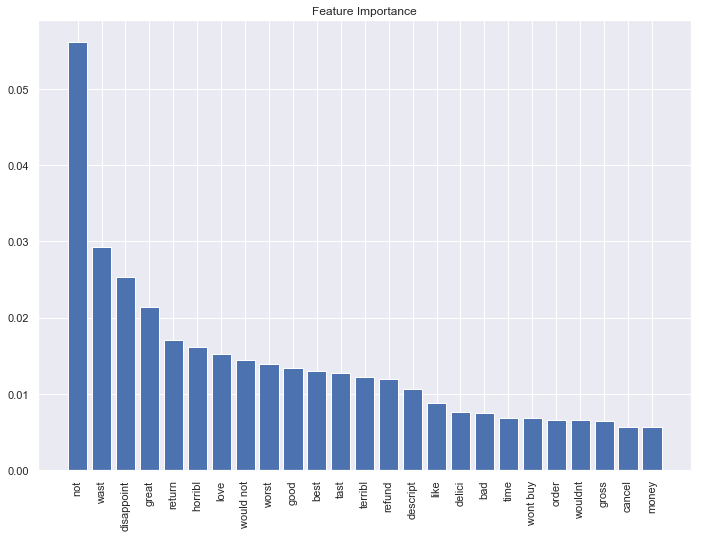

In [61]:
#### Feature Importance 

importances = model.feature_importances_

indices = np.argsort(importances)[::-1][:25]

names = bi_gram.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

In [62]:
%%time
############ DT, TfIdf, bi_gram, GridSearchCV 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                   df_sample['Score'].values,
                                                   shuffle=False,
                                                   test_size=0.3,
                                                   random_state=1)

tfidf = TfidfVectorizer(ngram_range=(2,2))

X_train = tfidf.fit_transform(X_train)

X_train = preprocessing.normalize(X_train)


X_test = tfidf.transform(X_test)

X_test = preprocessing.normalize(X_test)

print ("X_Train : ", X_train.shape)
print ("X_Test : ", X_test.shape)

X_Train :  (14000, 294050)
X_Test :  (6000, 294050)
Wall time: 4.97 s


In [ ]:
%%time 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

var = randint(2, 300)

model = DecisionTreeClassifier()
param_grid = {'max_depth': sorted(var.rvs(10))}

tscv = TimeSeriesSplit(n_splits=5)

gsv = GridSearchCV(model, param_grid, cv=tscv, verbose=1, scoring="f1", n_jobs=-1)

gsv.fit(X_train, y_train)
              
savetofile(gsv, "DT_tfidf_gsv")

print ("Best Param : ", gsv.best_params_)
print ("Best Score/Accuracy : ", gsv.best_score_ * 100)


In [ ]:
gsv = openfromfile("DT_tfidf_gsv")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,300)
plt.ylim(0.35,1)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

In [ ]:
%%time
### Accuracy DT 

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

model = DecisionTreeClassifier(max_depth=gsv.best_params_['max_depth'])
## max_depth = 

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

tree.export_graphviz(model, out_file="DT_gsv_tfidf.dot")

In [ ]:
# Calculate feature importances from decision trees
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = tfidf.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()